# Environment Setting

In [1]:
from __future__ import annotations

import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
from gymnasium.utils.env_checker import check_env
from collections import defaultdict, deque
import numpy as np
from tqdm import tqdm  # Progress bar
from typing import Optional
from gymnasium import spaces
import matplotlib.pyplot as plt

# Colab-compatible imports for interactive widgets
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output, HTML
    print("✅ Colab widgets available")
except ImportError:
    print("⚠️ ipywidgets not available - some interactive features may not work")
    # Fallback to matplotlib widgets for local environments
    try:
        from matplotlib.widgets import Button
        print("✅ Matplotlib widgets available as fallback")
    except ImportError:
        print("❌ No interactive widgets available")

import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time

import seaborn as sns
from matplotlib.patches import Patch

seed = 1310

print("✅ All libraries imported successfully!")
print("🔧 Setup optimized for Google Colab compatibility")

✅ Colab widgets available
✅ All libraries imported successfully!
🔧 Setup optimized for Google Colab compatibility


# Agent - Q-Learning with Q-table

- State space is small → we can store Q(s,a) in a table (dict of arrays)


In [ ]:
class BlackjackAgent_QLearning_Qtable:
    def __init__(self, env, episodes=1000, eps=0.1, alpha=0.1, gamma=0.9):
        """
        Initialize the agent.
        - env: the Blackjack environment
        - episodes: number of training episodes
        - eps: epsilon for epsilon-greedy (exploration rate)
        - alpha: learning rate (step size for Q update)
        - gamma: discount factor
        """
        self.env = env
        self.episodes = episodes
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        self.action_space = spaces.Discrete(2)
        self.action = ["stick", "hit"]

        # Storage for Q-values (for Q-learning), can later swap to NN
        self.Q = {}

    def get_action(self, state):
        """
        Decide which action to take given a state.
        - With probability eps: pick random action (exploration)
        - Otherwise: pick best action based on Q-values (exploitation)
        Returns: action
        """
        if state not in self.Q:
          self.Q[state] = np.zeros(self.action_space.n)

        if np.random.random() < self.eps:
          action = np.random.choice(self.action_space.n)
        else:
          action = np.argmax(self.Q[state])

        return action

    def update_q(self, state, action, reward, next_state, done):
        """
        Perform the Q-learning update rule:
        Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s',a') - Q(s,a) ]
        """
        # Initialize unseen states
        if state not in self.Q:
          self.Q[state] = np.zeros(self.action_space.n)

        if next_state not in self.Q:
          self.Q[next_state] = np.zeros(self.action_space.n)

        target = reward # Start with immediate reward

        # Add future value if game not over
        '''
        if the episode is not finished, then we also care about the future reward we might get
        `np.max(self.Q[next_state])` = best possible value I can get in the next state
        gamma helps reduce importance of far-away rewards
        add the future rewards to the immediate reward

        `self.Q[state][action]` = Q(s,a)
        This compare the current guess with the new target we have just computed
        `(target - Q(s,a))` is the error in the estimate
        multiply by learning rate `alpha` to take a small step toward fixing it
        '''
        if not done:
          target += self.gamma * np.max(self.Q[next_state])

        self.Q[state][action] += self.alpha * (target - self.Q[state][action])

    def train(self):
        """
        Main training loop:
        - For each episode:
            1. Reset environment
            2. Loop through steps until terminal state:
                - Choose action
                - Take action in env
                - Get reward + next state
                - Update Q-values
        - Track performance (e.g., average reward)

        updates Q-values, uses epsilon-greedy
        """

        episode_rewards = []

        for i in range(self.episodes):
          state, info = self.env.reset()
          done = False
          total_reward = 0
          while not done:
            action = self.get_action(state)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

          episode_rewards.append(total_reward)

        return episode_rewards

    def play(self, num_games=10):
        """
        Run the agent in evaluation mode (greedy policy only).
        Print/return results (e.g., wins, losses, draws).

        no updates, greedy only.
        """
        results = []

        for _ in range(num_games):

          state, info = self.env.reset()
          done = False
          total_reward = 0

          while not done:
            if state in self.Q:
              action = np.argmax(self.Q[state])
            else:
              action = self.env.action_space.sample()

            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward

          results.append(total_reward)

        # after all games, summarize
        print(f'Average reward: {np.mean(results):.4f}')
        print(f"Wins: {results.count(1)}, Losses: {results.count(-1)}, Draws: {results.count(0)}")

        return results




## Running the code

In [ ]:
if __name__ == "__main__":

    # Create Blackjack environment
    env = gym.make("Blackjack-v1", natural = True, sab = False)  # sab=False = default rules

    # Create agent
    agent = BlackjackAgent_QLearning_Qtable(env, episodes=50000, eps=0.1, alpha=1e-3, gamma=0.95)

    # Train the agent
    rewards = agent.train()
    print("Training finished.")

    # Evaluate performance
    agent.play(num_games=50)


The average reward: -0.2 \
Wins: 16, Losses: 29, Draws: 3 \
V shit



In [ ]:
class BlackjackAgent_QLearning_Qtable:
    def __init__(self, env, episodes=1000, eps=0.1, alpha=0.1, gamma=0.9):
        """
        Initialize the agent.
        - env: the Blackjack environment
        - episodes: number of training episodes
        - eps: epsilon for epsilon-greedy (exploration rate)
        - alpha: learning rate (step size for Q update)
        - gamma: discount factor
        """
        self.env = env
        self.episodes = episodes
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        self.action_space = spaces.Discrete(2)
        self.action = ["stick", "hit"]

        # Storage for Q-values (for Q-learning), can later swap to NN
        self.Q = {}

    def get_action(self, state):
        """
        Decide which action to take given a state.
        - With probability eps: pick random action (exploration)
        - Otherwise: pick best action based on Q-values (exploitation)
        Returns: action
        """
        if state not in self.Q:
          self.Q[state] = np.zeros(self.action_space.n)

        if np.random.random() < self.eps:
          action = np.random.choice(self.action_space.n)
        else:
          action = np.argmax(self.Q[state])

        return action

    def update_q(self, state, action, reward, next_state, done):
        """
        Perform the Q-learning update rule:
        Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s',a') - Q(s,a) ]
        """
        # Initialize unseen states
        if state not in self.Q:
          self.Q[state] = np.zeros(self.action_space.n)

        if next_state not in self.Q:
          self.Q[next_state] = np.zeros(self.action_space.n)

        target = reward # Start with immediate reward

        # Add future value if game not over
        '''
        if the episode is not finished, then we also care about the future reward we might get
        `np.max(self.Q[next_state])` = best possible value I can get in the next state
        gamma helps reduce importance of far-away rewards
        add the future rewards to the immediate reward

        `self.Q[state][action]` = Q(s,a)
        This compare the current guess with the new target we have just computed
        `(target - Q(s,a))` is the error in the estimate
        multiply by learning rate `alpha` to take a small step toward fixing it
        '''
        if not done:
          target += self.gamma * np.max(self.Q[next_state])

        self.Q[state][action] += self.alpha * (target - self.Q[state][action])

    def train(self):
        """
        Main training loop:
        - For each episode:
            1. Reset environment
            2. Loop through steps until terminal state:
                - Choose action
                - Take action in env
                - Get reward + next state
                - Update Q-values
        - Track performance (e.g., average reward)

        updates Q-values, uses epsilon-greedy
        """

        episode_rewards = []

        for i in range(self.episodes):
          state, info = self.env.reset()
          done = False
          total_reward = 0
          while not done:
            action = self.get_action(state)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

          episode_rewards.append(total_reward)

        return episode_rewards

    def play(self, num_games=10):
        """
        Run the agent in evaluation mode (greedy policy only).
        Print/return results (e.g., wins, losses, draws).

        no updates, greedy only.
        """
        results = []

        for _ in range(num_games):

          state, info = self.env.reset()
          done = False
          total_reward = 0

          while not done:
            if state in self.Q:
              action = np.argmax(self.Q[state])
            else:
              action = self.env.action_space.sample()

            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward

          results.append(total_reward)

        # after all games, summarize
        print(f'Average reward: {np.mean(results):.4f}')
        print(f"Wins: {results.count(1)}, Losses: {results.count(-1)}, Draws: {results.count(0)}")

        return results

    def save(self, filepath="qtable_agent.pth"):
        """
        Save the learned Q-table and parameters to a file using torch.
        """
        checkpoint = {
            "Q": self.Q,
            "episodes": self.episodes,
            "eps": self.eps,
            "alpha": self.alpha,
            "gamma": self.gamma
        }
        torch.save(checkpoint, filepath, pickle_protocol=4)
        print(f"Agent saved to {filepath}")

    def load(self, filepath="qtable_agent.pth"):
        """
        Load the Q-table and parameters from a file using torch.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        checkpoint = torch.load(filepath, map_location=device, weights_only=False)
        self.Q = checkpoint["Q"]
        self.episodes = checkpoint["episodes"]
        self.eps = checkpoint["eps"]
        self.alpha = checkpoint["alpha"]
        self.gamma = checkpoint["gamma"]
        print(f"Agent loaded from {filepath}")

    def plot_rewards(self, rewards):
        """
        Plot the reward obtained in each episode.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(rewards)
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("Q-Table: Rewards per Episode")
        plt.show()



In [ ]:
if __name__ == "__main__":

    episodes = 5000
    eps = 0.1
    alpha = 1e-3
    gamma = 0.99
    # Create Blackjack environment
    env = gym.make("Blackjack-v1", natural = True, sab = False)  # sab=False = default rules

    # Create agent
    agent = BlackjackAgent_QLearning_Qtable(env, episodes=episodes, eps=eps, alpha=alpha, gamma=gamma)

    # Train the agent
    rewards = agent.train()
    print("Training finished.")
    agent.play(num_games=100)

    # Save the agent
    agent.save(f"blackjack_qtable_agent_episode{episodes}_eps{eps}_alpha{alpha}_gamma{gamma}.pth")

In [ ]:
if __name__ == "__main__":

    episodes = 5000
    eps = 0.1
    alpha = 1e-3
    gamma = 0.99
    # Create Blackjack environment
    env = gym.make("Blackjack-v1", natural = True, sab = False)  # sab=False = default rules

    # Create agent
    agent = BlackjackAgent_QLearning_Qtable(env, episodes=episodes, eps=eps, alpha=alpha, gamma=gamma)
    # Load the agent
    agent.load(f"blackjack_qtable_agent_episode{episodes}_eps{eps}_alpha{alpha}_gamma{gamma}.pth")

    # Evaluate performance after loading
    agent.play(num_games=100)

    # For visualization of training progress
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress")
    plt.show()

# Agent - Q-Learning with DQN

In [12]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

class DQNNetwork(nn.Module):
    def __init__(self, state_size=3, action_size=2):
        super(DQNNetwork, self).__init__()

        # Improved architecture with layer normalization and dropout
        self.network = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.LayerNorm(128),  # Layer normalization for stability
            nn.ReLU(),
            nn.Dropout(0.1),    # Light dropout for regularization
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, action_size)
        )

        # Better weight initialization
        self._init_weights()

    def _init_weights(self):
        """Improved initialization for stable training"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        return self.network(x)

class BlackjackAgent_DQN:
    def __init__(self, env, episodes=25000, lr=0.0003, gamma=0.99, eps_start=1.0, eps_end=0.01, eps_decay=0.9998):
        self.env = env
        self.episodes = episodes
        self.lr = lr
        self.gamma = gamma
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay

        self.state_size = 3
        self.action_size = env.action_space.n

        self.q_network = DQNNetwork(self.state_size, self.action_size)
        self.target_network = DQNNetwork(self.state_size, self.action_size)

        # Improved optimizer with weight decay and scheduling
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=self.lr, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.8, patience=2000)

        self.update_target_network()
        self.replay_buffer = ReplayBuffer(capacity=50000)
        self.batch_size = 128  # Larger batch for more stable gradients
        self.target_update_freq = 200  # More frequent updates for shorter training
        self.min_replay_size = 2000   # Start training sooner for shorter episodes
        self.step_count = 0

    def state_to_tensor(self, state):
        # Normalize state for better training stability
        player_sum = (state[0] - 12) / 9.0      # Normalize to roughly [-1, 1]
        dealer_card = (state[1] - 6) / 5.0      # Normalize to roughly [-1, 1]
        usable_ace = float(state[2])            # Already 0 or 1

        return torch.tensor([player_sum, dealer_card, usable_ace], dtype=torch.float32).unsqueeze(0)

    def get_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            state_tensor = self.state_to_tensor(state)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def train_step(self):
        if len(self.replay_buffer) < self.min_replay_size:
            return None

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        state_batch = torch.stack([self.state_to_tensor(s).squeeze(0) for s in states])
        action_batch = torch.tensor(actions, dtype=torch.long)
        reward_batch = torch.tensor(rewards, dtype=torch.float32)
        next_state_batch = torch.stack([self.state_to_tensor(s).squeeze(0) for s in next_states])
        done_batch = torch.tensor(dones, dtype=torch.bool)

        current_q_values = self.q_network(state_batch).gather(1, action_batch.unsqueeze(1))

        # Double DQN: Use main network to select actions, target network to evaluate
        with torch.no_grad():
            next_actions = self.q_network(next_state_batch).argmax(1)
            next_q_values = self.target_network(next_state_batch).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            targets = reward_batch + (self.gamma * next_q_values * ~done_batch)

        # Use MSE loss with smaller learning steps for stability
        loss = nn.MSELoss()(current_q_values.squeeze(), targets)

        self.optimizer.zero_grad()
        loss.backward()

        # More aggressive gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 0.5)

        self.optimizer.step()

        # Update learning rate based on loss
        self.scheduler.step(loss.item())

        return loss.item()

    def train(self):
        episode_rewards = []
        episode_losses = []
        q_values_history = []
        win_rates = []

        print(f"Training Improved DQN for {self.episodes} episodes...")
        print(f"🧠 Network: {sum(p.numel() for p in self.q_network.parameters())} parameters")

        for episode in range(self.episodes):
            state, info = self.env.reset()
            done = False
            total_reward = 0
            episode_loss = 0
            episode_q_values = []
            steps = 0

            while not done:
                action = self.get_action(state, training=True)

                # Track Q-values for analysis
                state_tensor = self.state_to_tensor(state)
                with torch.no_grad():
                    q_vals = self.q_network(state_tensor)
                    episode_q_values.append(q_vals.max().item())

                next_state, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                self.replay_buffer.add(state, action, reward, next_state, done)

                if len(self.replay_buffer) >= self.min_replay_size:
                    loss = self.train_step()
                    if loss is not None:
                        episode_loss += loss
                        steps += 1

                self.step_count += 1
                if self.step_count % self.target_update_freq == 0:
                    self.update_target_network()

                state = next_state
                total_reward += reward

            # Epsilon decay
            if self.epsilon > self.eps_end:
                self.epsilon = max(self.eps_end, self.epsilon * self.eps_decay)

            episode_rewards.append(total_reward)
            episode_losses.append(episode_loss / max(steps, 1))
            q_values_history.append(np.mean(episode_q_values) if episode_q_values else 0)

            # Calculate rolling win rate
            if episode >= 999:
                recent_rewards = episode_rewards[-1000:]
                win_rate = (np.array(recent_rewards) == 1).mean() * 100
                win_rates.append(win_rate)

            if (episode + 1) % 1000 == 0:
                window_size = min(1000, episode + 1)
                avg_reward = np.mean(episode_rewards[-window_size:])
                avg_loss = np.mean(episode_losses[-window_size:])
                avg_q = np.mean(q_values_history[-window_size:])
                current_lr = self.optimizer.param_groups[0]['lr']

                # Calculate win rate for the window
                recent_wins = sum(1 for r in episode_rewards[-window_size:] if r == 1)
                win_rate = (recent_wins / window_size) * 100

                print(f"Episode {episode + 1:5d}/{self.episodes} | "
                      f"Avg Reward: {avg_reward:6.3f} | "
                      f"Win Rate: {win_rate:5.1f}% | "
                      f"Epsilon: {self.epsilon:.3f} | "
                      f"Loss: {avg_loss:.5f} | "
                      f"Avg Q: {avg_q:.2f} | "
                      f"LR: {current_lr:.6f}")

        print("Training completed!")

        # Store training history for plotting
        self.training_history = {
            'rewards': episode_rewards,
            'losses': episode_losses,
            'q_values': q_values_history,
            'win_rates': win_rates
        }

        return episode_rewards

    def play(self, num_games=100):
        results = []
        for _ in range(num_games):
            state, info = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.get_action(state, training=False)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated
                state = next_state
                total_reward += reward

            results.append(total_reward)

        avg_reward = np.mean(results)
        wins = results.count(1)
        losses = results.count(-1)
        draws = results.count(0)
        win_rate = wins / num_games * 100

        print(f"Average reward: {avg_reward:.4f}")
        print(f"Wins: {wins} ({win_rate:.1f}%), Losses: {losses}, Draws: {draws}")
        return results

    def save(self, filepath="dqn_agent.pth"):
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'episodes': self.episodes,
            'epsilon': self.epsilon,
            'training_history': getattr(self, 'training_history', {})
        }, filepath)
        print(f"Model saved as {filepath}")

    def load(self, filepath="dqn_agent.pth"):
        checkpoint = torch.load(filepath)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.training_history = checkpoint.get('training_history', {})
        print(f"Model loaded from {filepath}")

    def plot_training_results(self, save_plots=True):
        """Create comprehensive training visualization"""
        if not hasattr(self, 'training_history'):
            print("No training history available. Train the model first.")
            return

        history = self.training_history
        rewards = history['rewards']
        losses = history['losses']
        q_values = history['q_values']
        win_rates = history['win_rates']

        plt.figure(figsize=(16, 12))

        # Plot 1: Episode rewards with moving averages
        plt.subplot(2, 3, 1)
        plt.plot(rewards, alpha=0.3, color='lightblue', label='Episode rewards')

        # Moving averages
        if len(rewards) > 100:
            ma_100 = np.convolve(rewards, np.ones(100)/100, mode='valid')
            plt.plot(range(99, len(rewards)), ma_100, color='orange', linewidth=2, label='100-episode MA')

        if len(rewards) > 1000:
            ma_1000 = np.convolve(rewards, np.ones(1000)/1000, mode='valid')
            plt.plot(range(999, len(rewards)), ma_1000, color='red', linewidth=3, label='1000-episode MA')

        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title('DQN Learning Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 2: Training loss
        plt.subplot(2, 3, 2)
        if losses:
            plt.plot(losses, color='red', alpha=0.6)
            if len(losses) > 100:
                loss_ma = np.convolve(losses, np.ones(100)/100, mode='valid')
                plt.plot(range(99, len(losses)), loss_ma, color='darkred', linewidth=2, label='100-episode MA')
            plt.xlabel('Episode')
            plt.ylabel('Average Loss')
            plt.title('Training Loss')
            plt.grid(True, alpha=0.3)
            plt.legend()

        # Plot 3: Q-values evolution
        plt.subplot(2, 3, 3)
        if q_values:
            plt.plot(q_values, color='green', alpha=0.6)
            if len(q_values) > 100:
                q_ma = np.convolve(q_values, np.ones(100)/100, mode='valid')
                plt.plot(range(99, len(q_values)), q_ma, color='darkgreen', linewidth=2, label='100-episode MA')
            plt.xlabel('Episode')
            plt.ylabel('Average Q-Value')
            plt.title('Q-Value Evolution')
            plt.grid(True, alpha=0.3)
            plt.legend()

        # Plot 4: Win rate progression
        plt.subplot(2, 3, 4)
        if win_rates:
            episodes_offset = len(rewards) - len(win_rates)
            plt.plot(range(episodes_offset, len(rewards)), win_rates, color='purple', linewidth=2)
            plt.axhline(y=43, color='red', linestyle='--', alpha=0.7, label='Optimal Blackjack (~43%)')
            plt.xlabel('Episode')
            plt.ylabel('Win Rate (%)')
            plt.title('Win Rate Progression (1000-episode window)')
            plt.grid(True, alpha=0.3)
            plt.legend()

        # Plot 5: Performance segments
        plt.subplot(2, 3, 5)
        segments = 20
        segment_size = len(rewards) // segments
        segment_avgs = []
        segment_wins = []

        for i in range(segments):
            start_idx = i * segment_size
            end_idx = min((i + 1) * segment_size, len(rewards))
            segment_rewards = rewards[start_idx:end_idx]
            segment_avgs.append(np.mean(segment_rewards))
            segment_wins.append((np.array(segment_rewards) == 1).mean() * 100)

        x_labels = [f"{i*segment_size+1}-{min((i+1)*segment_size, len(rewards))}" for i in range(segments)]

        plt.bar(range(segments), segment_wins, color='skyblue', alpha=0.7, edgecolor='navy')
        plt.axhline(y=43, color='red', linestyle='--', alpha=0.7, label='Optimal (~43%)')
        plt.xlabel('Training Segment')
        plt.ylabel('Win Rate (%)')
        plt.title('Win Rate by Training Segment')
        plt.xticks(range(0, segments, 4), [x_labels[i] for i in range(0, segments, 4)], rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Plot 6: Epsilon decay
        plt.subplot(2, 3, 6)
        epsilon_history = []
        eps = 1.0
        eps_decay = self.eps_decay
        eps_end = self.eps_end

        for _ in range(len(rewards)):
            epsilon_history.append(eps)
            if eps > eps_end:
                eps = max(eps_end, eps * eps_decay)

        plt.plot(epsilon_history, color='orange', linewidth=2)
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.title('Exploration Rate (Epsilon) Decay')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_plots:
            plt.savefig('dqn_training_analysis.png', dpi=300, bbox_inches='tight')
            print("📊 Training plots saved as 'dqn_training_analysis.png'")

        plt.show()

## Running the code for "Agent - Q-Learning with DQN"

🚀 Starting Enhanced DQN Training (10,000 Episodes)...
🎯 Optimizations: Layer Norm + AdamW + Grad Clipping + LR Scheduling
🧠 Architecture: 128→64 with normalization and dropout
📊 Logging every 1,000 episodes with win rate tracking
Training Improved DQN for 10000 episodes...
🧠 Network: 9282 parameters
Episode  1000/10000 | Avg Reward: -0.441 | Win Rate:  23.7% | Epsilon: 0.606 | Loss: 0.00000 | Avg Q: 2.53 | LR: 0.000500
Episode  2000/10000 | Avg Reward: -0.391 | Win Rate:  26.0% | Epsilon: 0.368 | Loss: 1.99876 | Avg Q: 1.19 | LR: 0.000500
Episode  3000/10000 | Avg Reward: -0.125 | Win Rate:  35.0% | Epsilon: 0.223 | Loss: 0.53742 | Avg Q: 0.03 | LR: 0.000500
Episode  4000/10000 | Avg Reward: -0.092 | Win Rate:  37.1% | Epsilon: 0.135 | Loss: 0.51436 | Avg Q: 0.03 | LR: 0.000500
Episode  5000/10000 | Avg Reward: -0.086 | Win Rate:  36.9% | Epsilon: 0.082 | Loss: 0.50884 | Avg Q: 0.02 | LR: 0.000400
Episode  6000/10000 | Avg Reward: -0.089 | Win Rate:  35.6% | Epsilon: 0.050 | Loss: 0.50

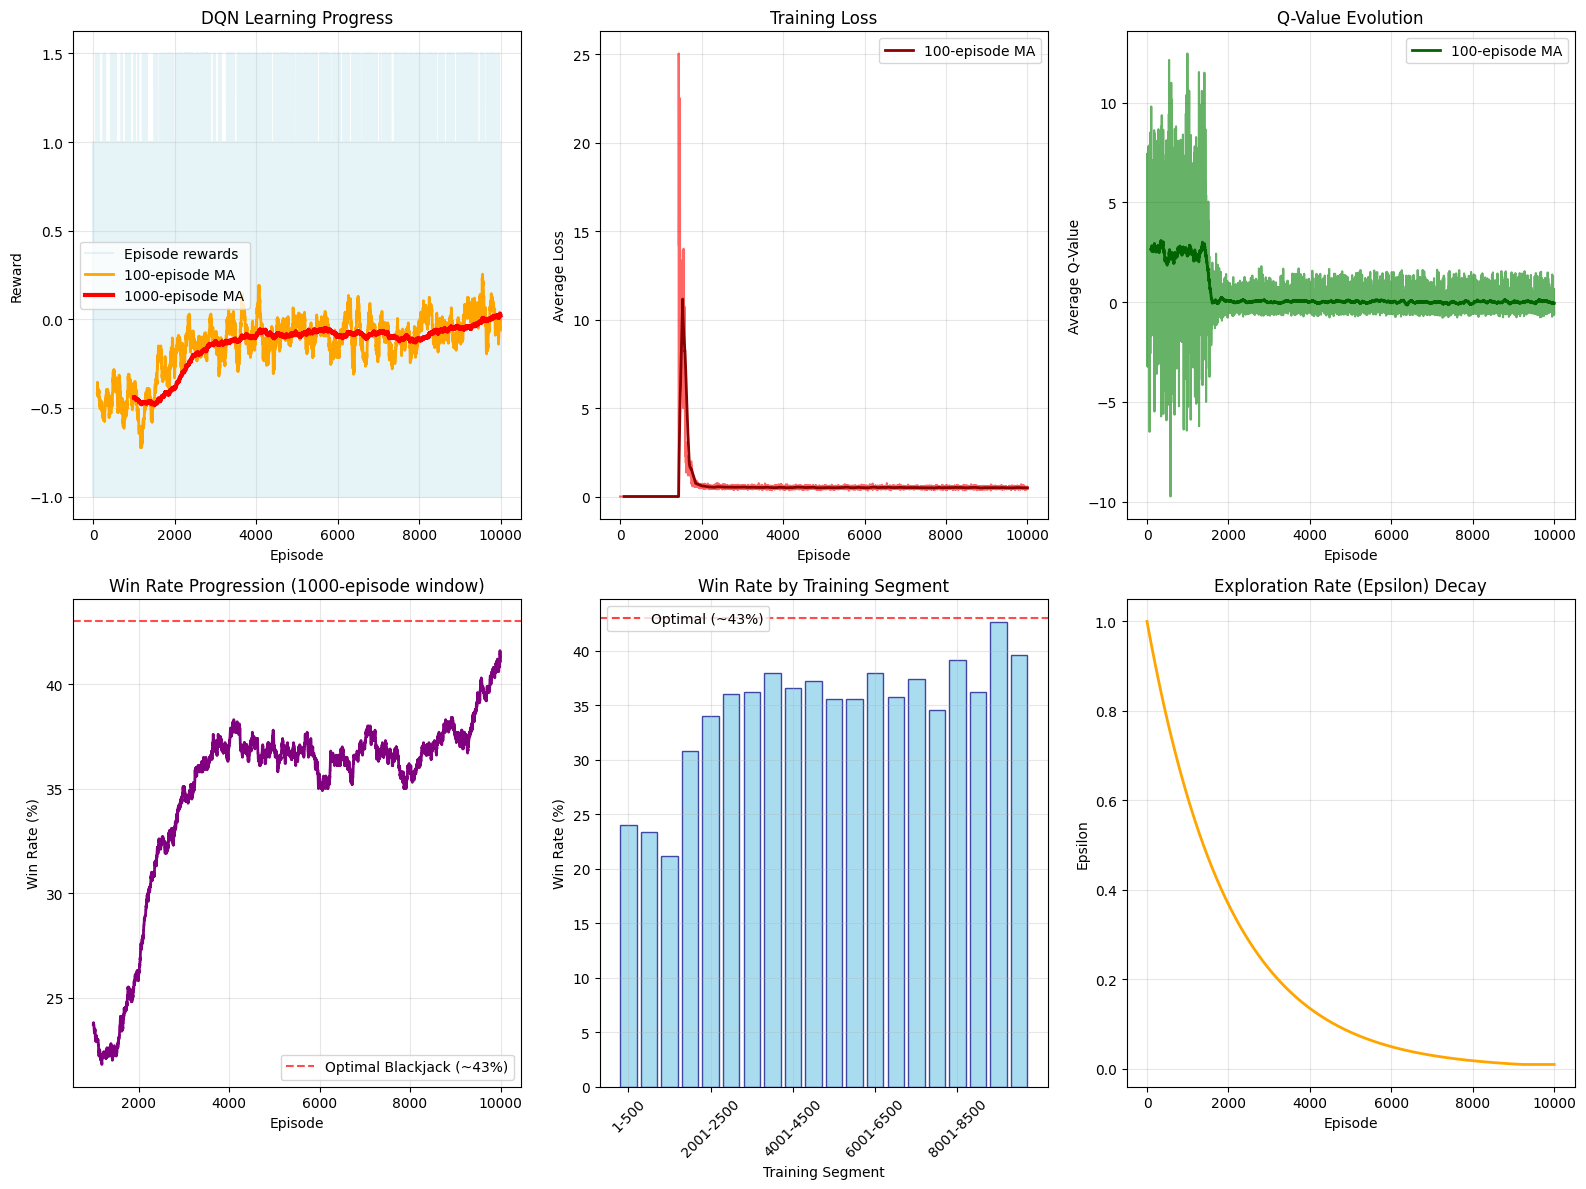


🎉 Enhanced DQN Training Complete!
📈 Check 'dqn_training_analysis.png' for detailed training analysis
💾 Model ready for use in interactive game!


In [15]:
if __name__ == "__main__":
    env = gym.make("Blackjack-v1", natural=True, sab=False)

    # Enhanced DQN optimized for 10,000 episodes
    agent = BlackjackAgent_DQN(
        env=env,
        episodes=10000,   # Reduced episodes for faster training
        lr=0.0005,        # Slightly higher LR for faster convergence
        gamma=0.99,
        eps_start=1.0,
        eps_end=0.01,
        eps_decay=0.9995  # Faster epsilon decay for shorter training
    )

    print("🚀 Starting Enhanced DQN Training (10,000 Episodes)...")
    print("🎯 Optimizations: Layer Norm + AdamW + Grad Clipping + LR Scheduling")
    print("🧠 Architecture: 128→64 with normalization and dropout")
    print("📊 Logging every 1,000 episodes with win rate tracking")
    print("=" * 70)

    rewards = agent.train()

    print("\n" + "=" * 60)
    print("🎮 Final Evaluation...")

    # Comprehensive evaluation
    agent.play(num_games=500)

    # Save model
    agent.save("dqn_agent.pth")
    print("✅ Model saved as dqn_agent.pth")

    # Create comprehensive training plots
    print("\n📊 Generating Training Analysis...")
    agent.plot_training_results(save_plots=True)

    print("\n🎉 Enhanced DQN Training Complete!")
    print("📈 Check 'dqn_training_analysis.png' for detailed training analysis")
    print("💾 Model ready for use in interactive game!")

# Agent - Q-Learing with Actor-Critic Method

## 🎭 Actor–Critic: The Concept

Think of the agent as having **two brains** working together:

1. **Actor (the decision maker)**

   * Learns the **policy** $\pi_\theta(a|s)$ — i.e., “what action should I take in this state?”
   * It’s usually a neural network that outputs probabilities over actions (via softmax).

2. **Critic (the evaluator)**

   * Learns the **value function** $V_w(s)$ — i.e., “how good is this state?”
   * Helps the Actor improve by providing a baseline: *Was that action better than expected?*

---

### 🔑 The flow of learning

1. Actor picks an action $a$ in state $s$.
2. Environment gives reward $r$ and next state $s'$.
3. Critic estimates the **TD error**:

   $$
   \delta = r + \gamma V_w(s') - V_w(s)
   $$

   This tells us whether things went better or worse than expected.
4. Critic updates its value network with this TD error.
5. Actor updates its policy:

   * If $\delta > 0$, the chosen action is reinforced (more likely next time).
   * If $\delta < 0$, the chosen action is weakened.

---

### Why it’s powerful

* **Actor** gives us **stochastic exploration** for free (sampling actions).
* **Critic** stabilizes training (reduces variance compared to vanilla Policy Gradient).
* Together, they balance **exploration** and **evaluation**.

---

### 📌 Key differences from Q-Learning / DQN

| Method       | Learns what?                                          | Exploration style                  |
| ------------ | ----------------------------------------------------- | ---------------------------------- |
| Q-Learning   | Action-value function $Q(s,a)$                        | ε-greedy                           |
| DQN          | Approximates $Q(s,a)$ with NN                         | ε-greedy                           |
| Actor-Critic | Actor learns policy $\pi$, Critic learns value $V(s)$ | Sampling from Actor’s distribution |

---


## Resources:
https://www.geeksforgeeks.org/machine-learning/actor-critic-algorithm-in-reinforcement-learning/ \
\
https://medium.com/intro-to-artificial-intelligence/the-actor-critic-reinforcement-learning-algorithm-c8095a655c14 \
\
http://www.incompleteideas.net/book/RLbook2020.pdf page 353

#### Try with geeksforgeeks method

In [ ]:
env = gym.make("Blackjack-v1", natural = True, sab = False)

# Define the actor and critic networks
actor = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(env.action_space.n, activation='softmax')
])

critic = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Define optimizer and loss functions
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Main training loop
num_episodes = 1000
gamma = 0.99

for episode in range(num_episodes):
    state, info = env.reset()
    episode_reward = 0

    with tf.GradientTape(persistent=True) as tape:
        for t in range(1, 10000):  # Limit the number of time steps
            # Choose an action using the actor
            action_probs = actor(np.array([state]))
            action = np.random.choice(env.action_space.n, p=action_probs.numpy()[0])

            # Take the chosen action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)

            # Compute the advantage
            state_value = critic(np.array([state]))[0, 0]
            next_state_value = critic(np.array([next_state]))[0, 0]
            advantage = reward + gamma * next_state_value - state_value

            # Compute actor and critic losses
            actor_loss = -tf.math.log(action_probs[0, action]) * advantage
            critic_loss = tf.square(advantage)

            episode_reward += reward

            # Update actor and critic
            actor_gradients = tape.gradient(actor_loss, actor.trainable_variables)
            critic_gradients = tape.gradient(critic_loss, critic.trainable_variables)
            actor_optimizer.apply_gradients(zip(actor_gradients, actor.trainable_variables))
            critic_optimizer.apply_gradients(zip(critic_gradients, critic.trainable_variables))

            if done:
                break

    if episode % 10 == 0:
        print(f'Episode {episode}, Reward: {episode_reward}')

env.close()


#### skeleton

In [ ]:
# Your code - Charis

class ActorCriticAgent:
    def __init__(self, env, episodes=1000, alpha=0.001, gamma=0.99):
        """
        env: the environment
        episodes: number of training episodes
        alpha: learning rate
        gamma: discount factor
        """
        self.env = env
        self.episodes = episodes
        self.alpha = alpha
        self.gamma = gamma

        obs_size = 3 # (player_sum, deler_card, usable_ace)
        '''
        state[0] = player_sum = the sum of your cards
        state[1] = the dealers' upcards (1-10)
        state[2] : Boolean = if I have an Ace
        '''
        action_size = self.env.action_space.n

        self.actor = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            # nn.Linear(128, 32),
            # nn.ReLU(),
            nn.Linear(128, action_size),
            nn.Softmax(dim=-1)
        )
        self.actor_optimizer  = optim.Adam(self.actor.parameters(),  lr=5e-5)


        self.critic = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
            # nn.Linear(128, 64),
            # nn.ReLU(),
            nn.Linear(128, 1) # we want a real number estimate => no activation
        )

        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.alpha)
        # Define Actor (policy network) and Critic (value network) here

    def action_space(self, state):
        '''
        Decide which action to take.
        - Actor outputs probabilities of each action.
        - Sample an action from this probability distribution.
        Returns: chosen action
        '''
        # your code
        state_t = torch.tensor([state[0], state[1], int(state[2])], dtype = torch.float32) # the int() is to transform a Boolean value into an integer
        state_t = state_t.unsqueeze(0)   # add batch dimension so nn works properly
        probs = self.actor(state_t).squeeze(0)
        dist = torch.distributions.Categorical(probs) # exploration comes naturally from sampling actions from the Actor’s probability distribution.
        action = dist.sample()

        # we need log probability of the chosen action for the policy gradient update
        return action.item(), dist.log_prob(action)


    def update(self, state, action, reward, next_state, done, log_prob):

      '''
      Core Actor–Critic update step:
      1. Critic computes TD error δ = r + γ V(s') - V(s)
      2. Critic updates its value network
      3. Actor updates its policy parameters using δ as feedback
      '''
      # your code

      # critic
      state_t = torch.tensor([state[0], state[1], int(state[2])], dtype=torch.float32)
      next_state_t = torch.tensor([next_state[0], next_state[1], int(next_state[2])], dtype=torch.float32)

      value = self.critic(state_t)  # V(s)
      with torch.no_grad():
        next_value = self.critic(next_state_t)
        target = reward if done else reward + self.gamma * next_value.item() # Compute TD target
      target = torch.tensor([target], dtype=torch.float32)

      TD_error = target - value

      # critic update
      critic_loss = TD_error.pow(2)
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
      self.critic_optimizer.step()

      # ---- Actor update (policy gradient with TD error) ----
      probs = self.actor(state_t.unsqueeze(0)).squeeze(0)
      dist  = torch.distributions.Categorical(probs)
      entropy = dist.entropy()

      actor_loss = -log_prob * TD_error.detach() - 0.01 * entropy
      self.actor_optimizer.zero_grad()
      actor_loss.backward()
      torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
      self.actor_optimizer.step()


    def train(self, log_interval=100):
        '''
        Main training loop:
        - For each episode:
            1. Reset environment
            2. Loop until terminal state:
                - Select action using Actor
                - Step environment
                - Update Actor & Critic
        '''
        # your code

        episode_rewards = []
        win_history = []   # store 1 if win, 0 otherwise

        for i in range(self.episodes):
          state, info = self.env.reset()
          done = False
          total_reward = 0
          while not done:
            action, log_prob = self.action_space(state)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update(state, action, reward, next_state, done, log_prob)
            state = next_state
            total_reward += reward

          episode_rewards.append(total_reward)

          if (i+1) % log_interval == 0:
            avg_reward = np.mean(episode_rewards[-log_interval:])
            print(f"[{i+1}/{self.episodes}] Average reward (last {log_interval} eps): {avg_reward:.2f}")


        return episode_rewards

    def play(self, num_games=10):
        '''
        Evaluate the trained policy:
        - Always pick action with highest probability
        - Track rewards and outcomes
        '''
        # your code
        results = []

        for _ in range(num_games):

          state, info = self.env.reset()
          done = False
          total_reward = 0

          while not done:
            # Convert state to tensor
            state_t = torch.tensor([state[0], state[1], int(state[2])], dtype=torch.float32)
            state_t = state_t.unsqueeze(0)  # Add batch dimension (so it's 1 sample of 3 features)

            # Actor network outputs probabilities
            probs = self.actor(state_t).squeeze(0) # Remove batch dimension

            # Greedy choice = argmax, not sampling
            action = torch.argmax(probs).item()

            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward

          results.append(total_reward)

        # after all games, summarize
        print(f'Average reward: {np.mean(results):.4f}')
        print(f"Wins: {results.count(1)}, Losses: {results.count(-1)}, Draws: {results.count(0)}")

        return results

    def save(self, filepath="actor_critic.pth"):
        checkpoint = {
            "actor_state_dict": self.actor.state_dict(),
            "critic_state_dict": self.critic.state_dict(),
            "actor_optimizer_state_dict": self.actor_optimizer.state_dict(),
            "critic_optimizer_state_dict": self.critic_optimizer.state_dict(),
            "episodes": self.episodes,
            "alpha": self.alpha,
            "gamma": self.gamma
        }
        torch.save(checkpoint, filepath)
        print(f"Model saved to {filepath}")

    def load(self, filepath="actor_critic.pth"):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        checkpoint = torch.load(filepath, map_location=device)
        self.actor.load_state_dict(checkpoint["actor_state_dict"])
        self.critic.load_state_dict(checkpoint["critic_state_dict"])
        self.actor_optimizer.load_state_dict(checkpoint["actor_optimizer_state_dict"])
        self.critic_optimizer.load_state_dict(checkpoint["critic_optimizer_state_dict"])
        print(f"Model loaded from {filepath}")




## Running the code for "Agent - Q-Learning with Actor-Critic Method"

In [ ]:
# if __name__ == "__main__":

#     # Create Blackjack environment
#     env = gym.make("Blackjack-v1", natural = True, sab = False)  # sab=False = default rules

#     # Create agent
#     agent = ActorCriticAgent(env, episodes=50000, alpha=1e-3, gamma=0.99)

#     # Train the agent
#     rewards = agent.train()
#     print("Training finished.")

#     # Evaluate performance
#     agent.play(num_games=100)


if __name__ == "__main__":
    episodes = 250000
    alpha = 1e-4
    gamma = 0.99

    env = gym.make("Blackjack-v1", natural = True, sab=False) # sab=False = default rules

    agent = ActorCriticAgent(env, episodes=episodes, alpha=alpha, gamma=gamma)

    # Train the agent
    reward = agent.train()
    print("Training finished.")

    # Save trained model
    agent.save(f"blackjack_actor_critic_episode{episodes}_alpha{alpha}_gamma{gamma}.pth")

    # Evaluate loaded agent
    agent.play(num_games=100)



I tried TT\
Average reward: -0.06\
Wins: 41, Losses: 50, Draws: 7

episodes=4000, alpha=1e-4, gamma=0.99, actor_optimizer lr = 5e-5\
average reward: 0.0000\
Wins:39, Losses:48, Draws:7\
saved in `blackjack_actor_critic.pth`

episodes=4000, alpha=1e-4, gamma=0.99, actor_optimizer lr = 5e-5 \
average reward: -0.075 \
Wins: 36, Losses: 51, Draws: 8 \
saved in `blackjack_actor_critic1.pth`

In [ ]:
if __name__ == "__main__":

    env = gym.make("Blackjack-v1", sab=False)

    # Later, reload
    new_agent = ActorCriticAgent(env)
    new_agent.load("blackjack_actor_critic1.pth")

    # Evaluate loaded agent
    new_agent.play(num_games=1000)


Interpreting average reward\
Avg reward = -0.13
→ On average, the agent loses 0.13 units per game.\
→ This means for every 100 games, it loses about 13 units.\
→ That’s actually realistic: under standard Blackjack rules, the casino has a house edge(long-term expected advantage the casino has over the player) of around 0.5% to 1%, which means the expected reward for a player is slightly negative, even with an optimal strategy.\
→ Your agent may be close to the best possible outcome already.\
\
Avg reward = +0.13\
→ On average, the agent wins 0.13 units per game.\
→ This means for every 100 games, it wins about 13 units.\
→ If this happens consistently, it suggests your environment might be set up with player-favorable rules (e.g., naturals pay 3:2, dealer stands on soft 17, no deck exhaustion).\
→ It could also mean your agent is exploiting some quirk of the Gym environment (since Gym Blackjack is a simplified abstraction).\

✅ Key takeaway

Negative average reward (~–0.1 to –0.2): normal, expected house edge. Your agent is likely close to optimal if it’s not losing heavily.

Zero average reward (0): agent roughly breaks even (better than random).

Positive average reward (>0): only possible with non-standard rules or bugs — in a fair casino setting, the player cannot have long-term positive expectation.

notes for alpha and gamma:
* alpha = learning rate
  * alpha -> 1: Training will jump around wildly => unstable learning
  * alpha -> 0: Training will be super slow
  * rule of thumb: `0.001 - 0.01`

* gamma = discounting factor, how much the agent cares about future rewards vs immediate rewards
  * gamma -> 1: Agent values long-term rewards
  * gamma -> 0: agent cares almost only about immediate rewards
  * rule of thumb: `0.9 - 0.99`

# Agent - Q-Learning with Temporal Difference Search

In [ ]:
# Your code - Emily

## Running the code for "Agent - Q-Learning with TD Search"

In [ ]:
if __name__ == "__main__":

    # Create Blackjack environment
    env = gym.make("Blackjack-v1", natural = True, sab = False)  # sab=False = default rules

    # Create agent
    agent = BlackjackAgent_QLearning_Qtable(env, episodes=50000, eps=0.1, alpha=0.1, gamma=0.9)

    # Train the agent
    rewards = agent.train()
    print("Training finished.")

    # Evaluate performance
    agent.play(num_games=50)


# Intuition with Blackjack example
Suppose:

You’re in state (sum=15, dealer=10, usable_ace=False).

You choose action hit.

You get reward 0 (game continues).

Next state is (sum=18, dealer=10, usable_ace=False).

Your table says Q(next_state) = [stick: 0.5, hit: -0.3].

Then:

reward = 0

np.max(Q[next_state]) = 0.5

target = 0 + gamma * 0.5 = 0.45 (if gamma=0.9)

Suppose current Q(state, hit) = 0.1.

Update:

Q(15,10,hit)←0.1+0.9(0.45−0.1)=0.415

So now the agent thinks hitting on 15 vs dealer 10 is worth about 0.415 expected value.

### VS Code Helper

In [ ]:
!python --version

In [ ]:
!pip freeze > requirement.txt

### git

In [ ]:
!git commit -m "msg"
!git push origin Blackjack

# Method to save and load the trained agent

In [ ]:
# def save(self, filepath="actor_critic.pth"):
#     checkpoint = {
#         "actor_state_dict": self.actor.state_dict(),
#         "critic_state_dict": self.critic.state_dict(),
#         "actor_optimizer_state_dict": self.actor_optimizer.state_dict(),
#         "critic_optimizer_state_dict": self.critic_optimizer.state_dict(),
#         "episodes": self.episodes,
#         "alpha": self.alpha,
#         "gamma": self.gamma
#     }
#     torch.save(checkpoint, filepath)
#     print(f"Model saved to {filepath}")


In [ ]:
# def load(self, filepath="actor_critic.pth"):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     checkpoint = torch.load(filepath, map_location=device)

#     self.actor.load_state_dict(checkpoint["actor_state_dict"])
#     self.critic.load_state_dict(checkpoint["critic_state_dict"])
#     self.actor_optimizer.load_state_dict(checkpoint["actor_optimizer_state_dict"])
#     self.critic_optimizer.load_state_dict(checkpoint["critic_optimizer_state_dict"])

#     print(f"Model loaded from {filepath} on {device}")


In [ ]:
# if __name__ == "__main__":
#     import gymnasium as gym

#     env = gym.make("Blackjack-v1", sab=False)
#     agent = ActorCriticAgent(env, episodes=10000, alpha=1e-3, gamma=0.99)

#     # Train the agent
#     agent.train()

#     # Save trained model
#     agent.save("blackjack_actor_critic.pth")

#     # Later, reload
#     new_agent = ActorCriticAgent(env)
#     new_agent.load("blackjack_actor_critic.pth")

#     # Evaluate loaded agent
#     new_agent.play(num_games=1000)


# 💾 Save Trained Models

Save your trained agents so they can be used with the interactive game script.

In [ ]:
# Save Improved Models for Interactive Game

# Save Q-table agent (if trained)
import pickle
import torch
import os

print("💾 Saving trained models for interactive game...")

# Save Q-table agent (from Q-learning cell)
try:
    # Look for Q-table agent in different possible variable names
    qtable_agent = None
    if 'agent' in locals() and hasattr(agent, 'Q'):
        qtable_agent = agent
    elif 'qtable_agent' in locals():
        qtable_agent = locals()['qtable_agent']

    if qtable_agent and hasattr(qtable_agent, 'Q'):
        with open('qtable_agent.pkl', 'wb') as f:
            pickle.dump(qtable_agent.Q, f)
        print("✅ Q-table agent saved as 'qtable_agent.pkl'")
        print(f"   Q-table size: {len(qtable_agent.Q)} states")
    else:
        print("⚠️ No Q-table agent found. Train the Q-table agent first!")
except Exception as e:
    print(f"❌ Error saving Q-table agent: {e}")

# Save DQN agent (improved version)
try:
    if 'agent' in locals() and hasattr(agent, 'q_network'):
        # Save the improved model
        model_path = 'dqn_agent_improved.pth'
        torch.save(agent.q_network.state_dict(), model_path)
        print(f"✅ Improved DQN agent saved as '{model_path}'")

        # Get model info
        total_params = sum(p.numel() for p in agent.q_network.parameters())
        trainable_params = sum(p.numel() for p in agent.q_network.parameters() if p.requires_grad)
        print(f"   Network parameters: {total_params:,} total, {trainable_params:,} trainable")

        # Also save training metadata
        metadata = {
            'episodes': agent.episodes,
            'lr': agent.lr,
            'gamma': agent.gamma,
            'eps_decay': agent.eps_decay,
            'final_epsilon': agent.epsilon,
            'buffer_size': len(agent.replay_buffer),
            'network_architecture': str(agent.q_network)
        }

        with open('dqn_training_info.pkl', 'wb') as f:
            pickle.dump(metadata, f)
        print("✅ Training metadata saved as 'dqn_training_info.pkl'")

    else:
        print("⚠️ No DQN agent found. Train the DQN agent first!")
except Exception as e:
    print(f"❌ Error saving DQN agent: {e}")

# Save Actor-Critic agent (if available)
try:
    ac_agent = None
    if 'agent' in locals() and hasattr(agent, 'actor'):
        ac_agent = agent
    elif 'ac_agent' in locals():
        ac_agent = locals()['ac_agent']

    if ac_agent and hasattr(ac_agent, 'actor'):
        # Save both actor and critic networks
        torch.save({
            'actor_state_dict': ac_agent.actor.state_dict(),
            'critic_state_dict': ac_agent.critic.state_dict(),
        }, 'actor_critic_agent.pth')
        print("✅ Actor-Critic agent saved as 'actor_critic_agent.pth'")
    else:
        print("⚠️ No Actor-Critic agent found.")
except Exception as e:
    print(f"❌ Error saving Actor-Critic agent: {e}")

print("\n🎮 Ready for Interactive Game!")
print("=" * 50)
print("📂 Available model files:")

# List available model files
model_files = {
    'qtable_agent.pkl': 'Q-Table Agent',
    'dqn_agent_improved.pth': 'Improved DQN Agent',
    'actor_critic_agent.pth': 'Actor-Critic Agent'
}

for filename, description in model_files.items():
    if os.path.exists(filename):
        file_size = os.path.getsize(filename) / 1024  # KB
        print(f"   ✅ {filename:<25} ({description}) - {file_size:.1f} KB")
    else:
        print(f"   ❌ {filename:<25} ({description}) - Not found")

print("\n🔧 To use in interactive game:")
print("1. Update AGENT_CONFIGS in interactive_blackjack_game.py")
print("2. Set the correct model paths:")
print("   - DQN: 'dqn_agent_improved.pth'")
print("   - Q-Table: 'qtable_agent.pkl'")
print("3. Run: python interactive_blackjack_game.py")